/workspaces/STdata_prediction/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Time len:  815
Split Speed finished. Start to generate Mask, Delta, Last_observed_X ...
Generate Mask, Delta, Last_observed_X finished. Start to shuffle and split dataset ...
Finished
Model Structure:  LGnet(
  (il): Linear(in_features=1428, out_features=325, bias=True)
  (fl): Linear(in_features=1428, out_features=325, bias=True)
  (ol): Linear(in_features=1428, out_features=325, bias=True)
  (cl): Linear(in_features=1428, out_features=325, bias=True)
  (fc): Linear(in_features=325, out_features=325, bias=True)
  (gamma_z_l): FilterLinear(in_features=325, out_features=325, bias=True)
  (gamma_z_prime_l): FilterLinear(in_features=325, out_features=325, bias=True)
  (q_for_memory): Linear(in_features=975, out_features=128, bias=True)
)
Start Training ... 
Output type dermined by the model


/tmp/ipykernel_547780/3926160509.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_batchs)


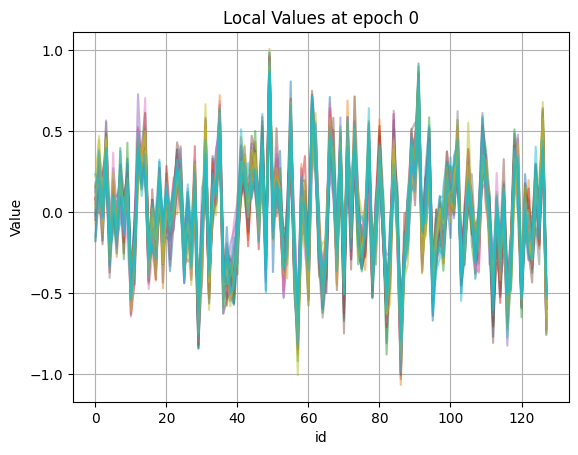

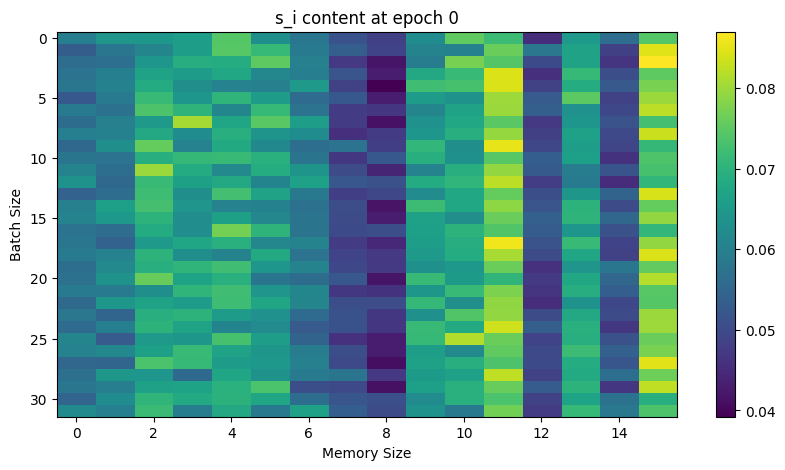

/tmp/ipykernel_547780/3926160509.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_batchs)


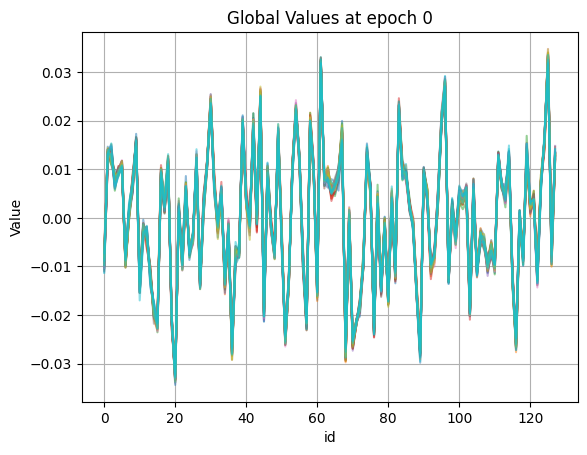

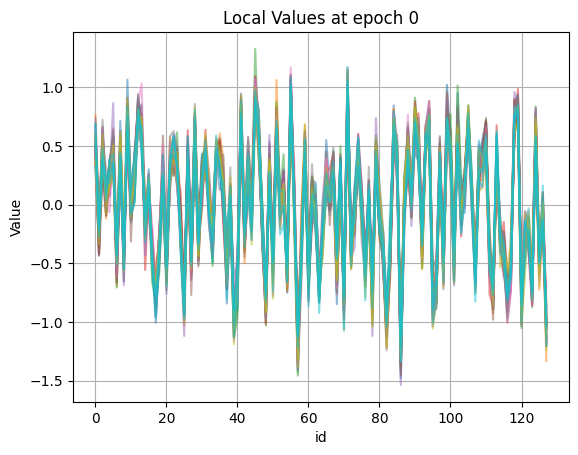

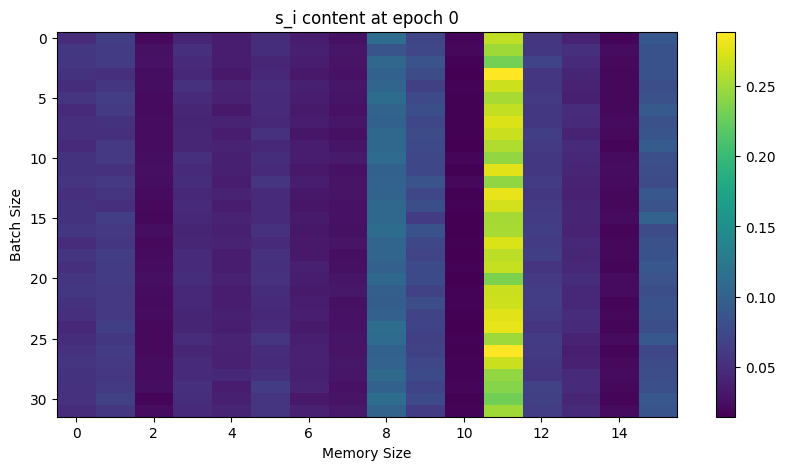

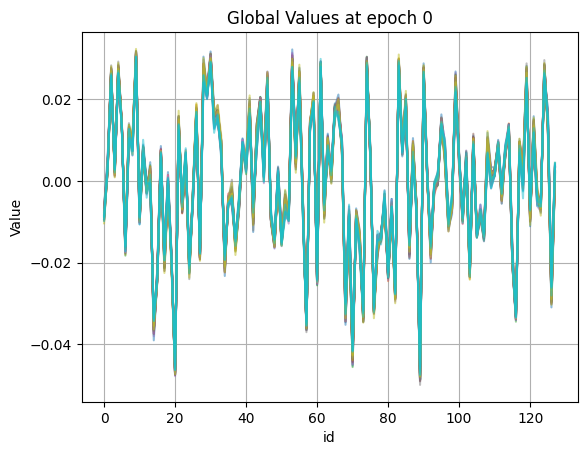

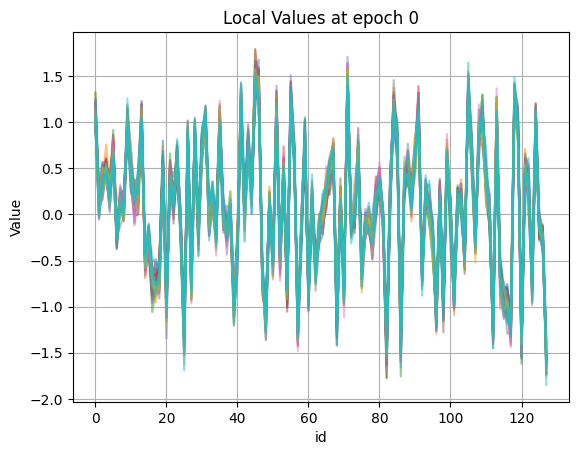

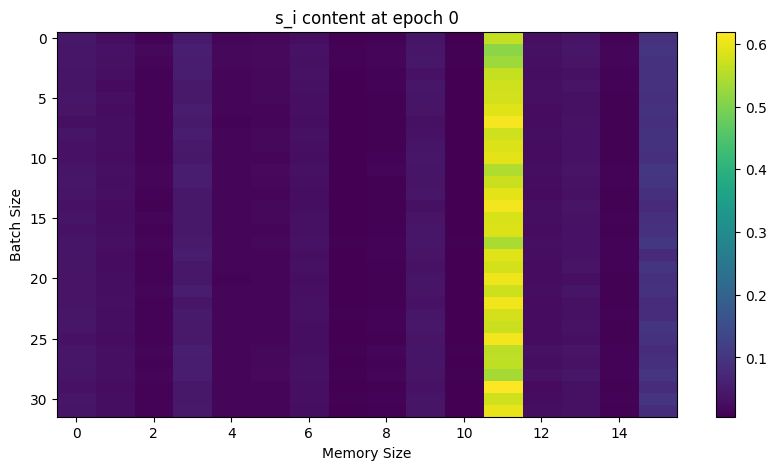

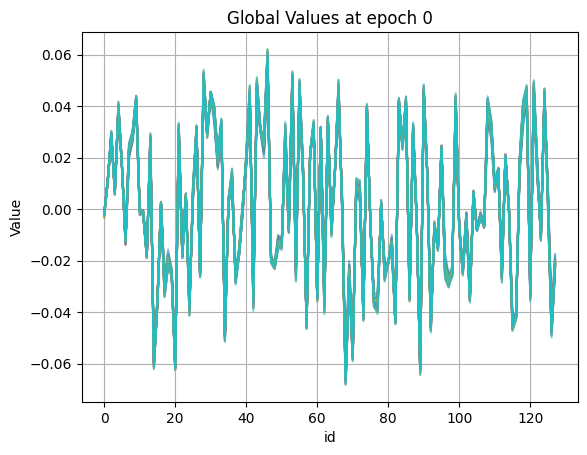

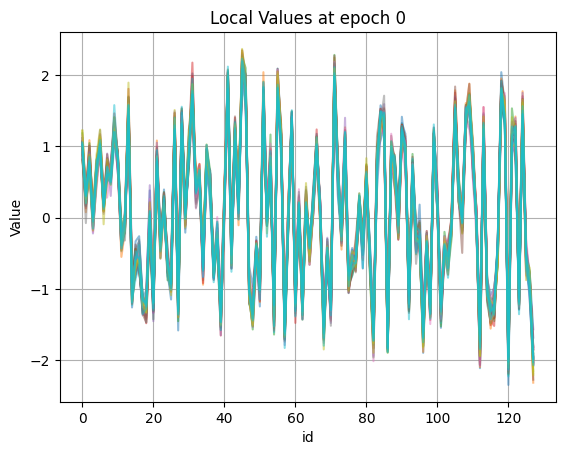

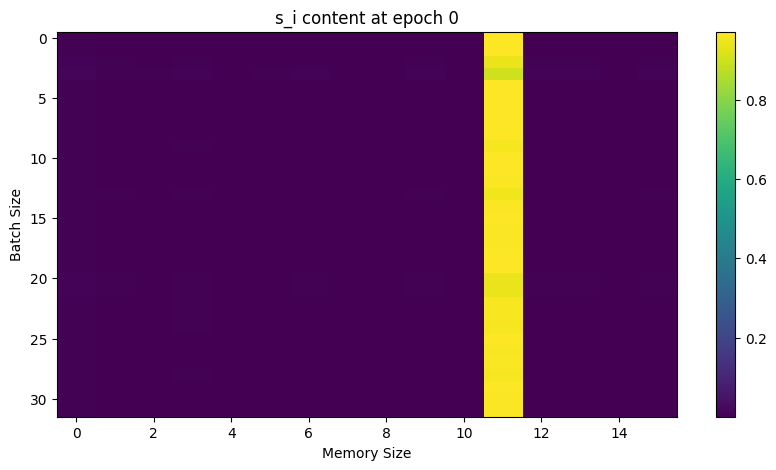

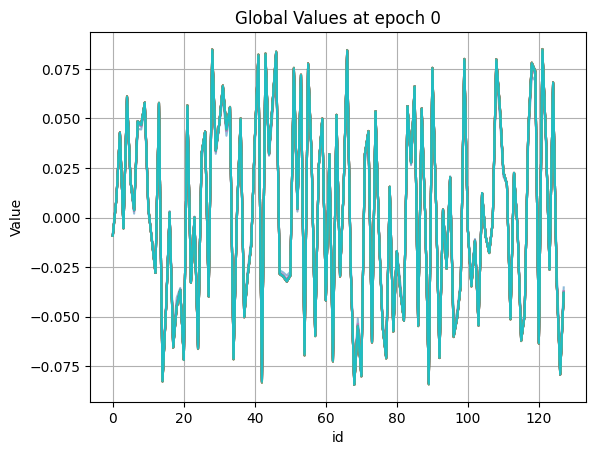

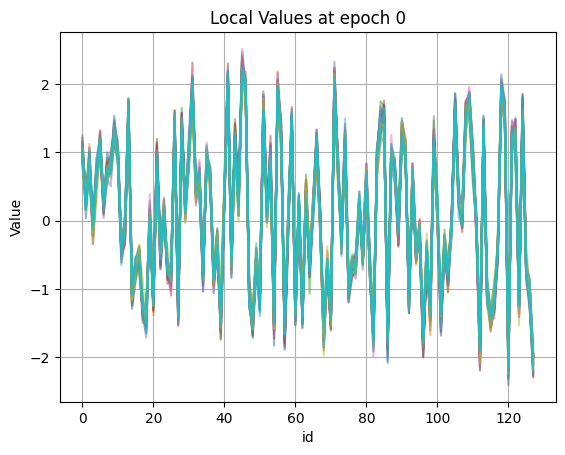

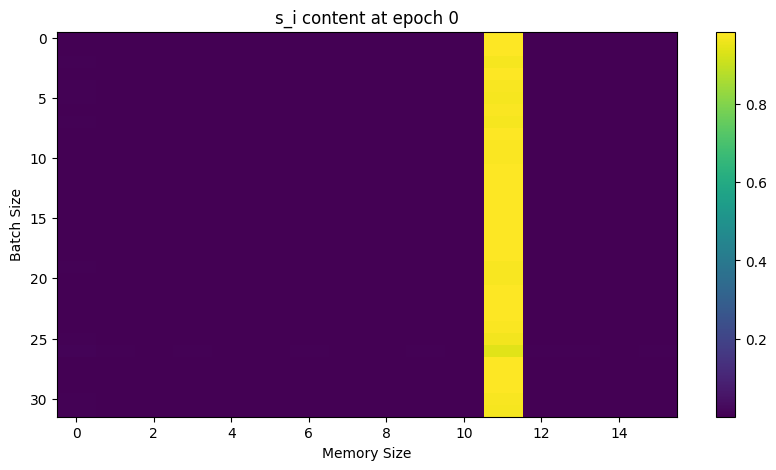

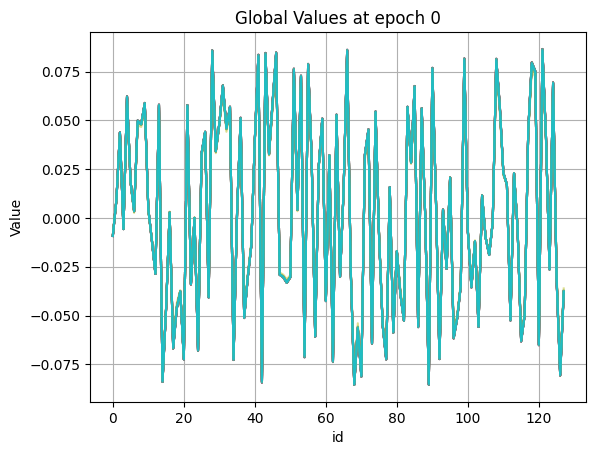

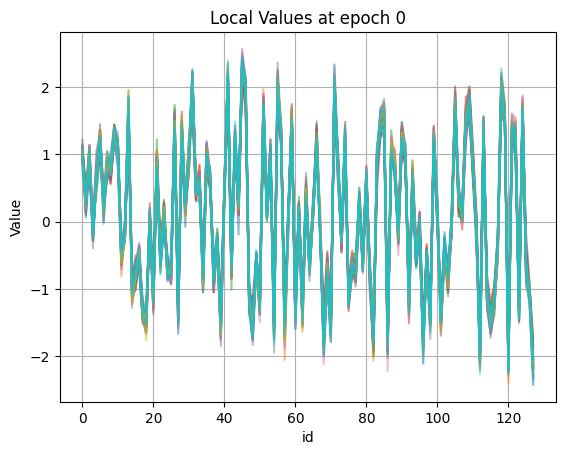

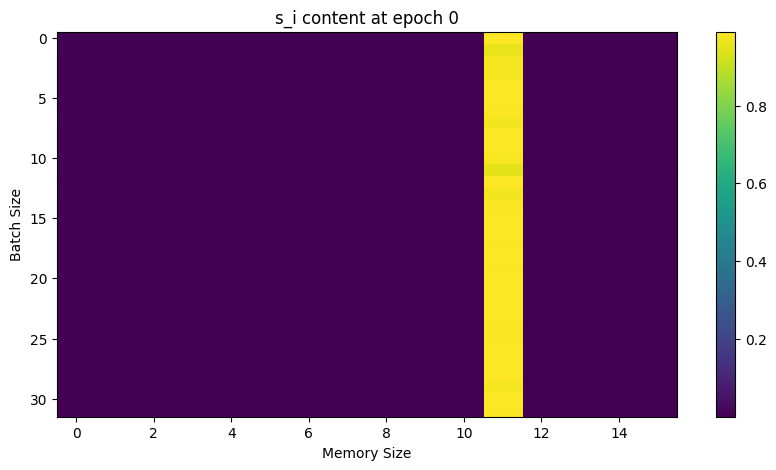

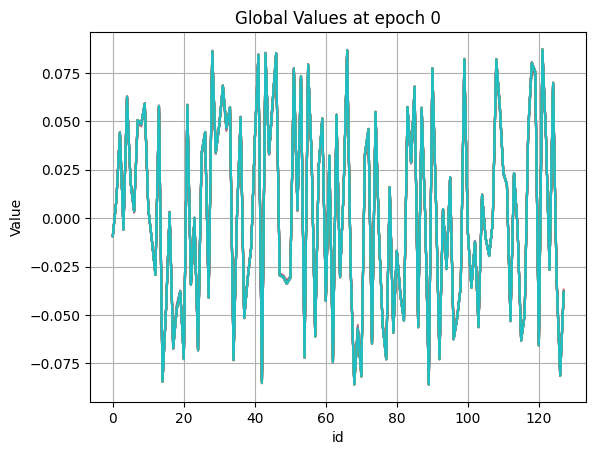

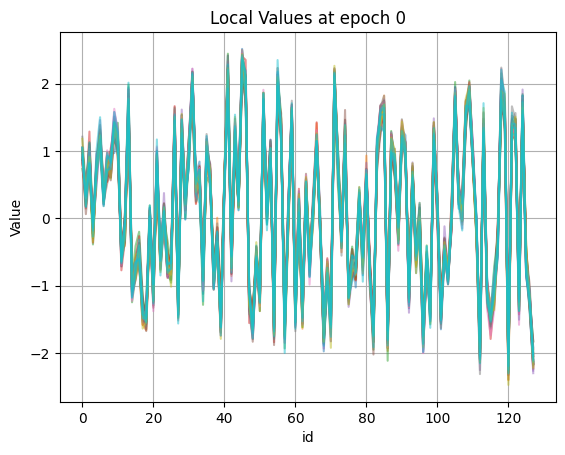

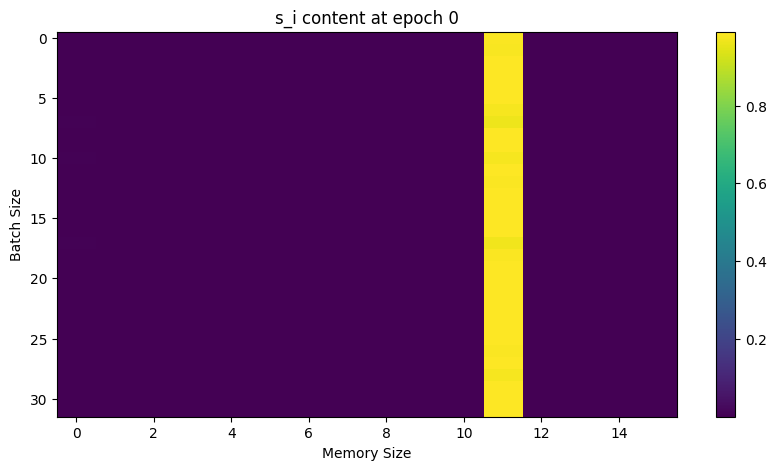

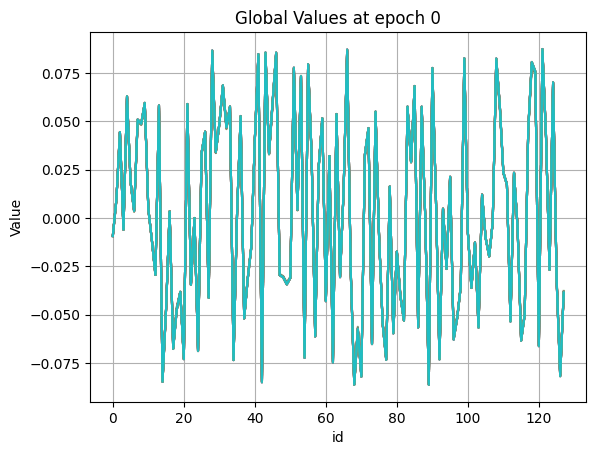

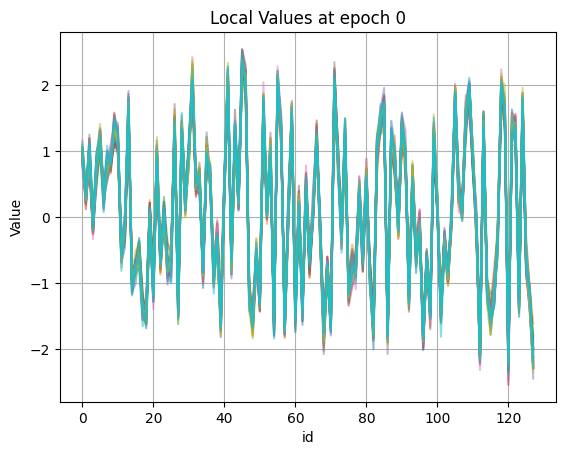

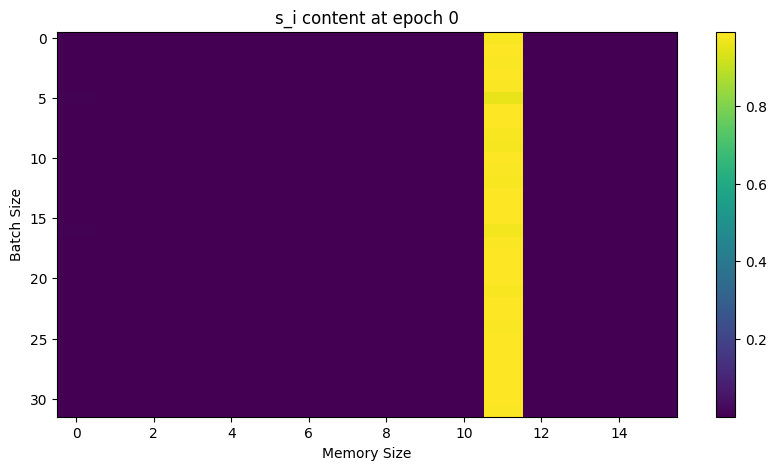

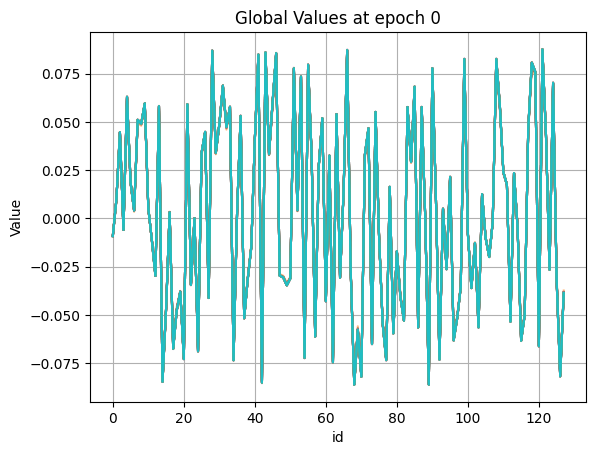

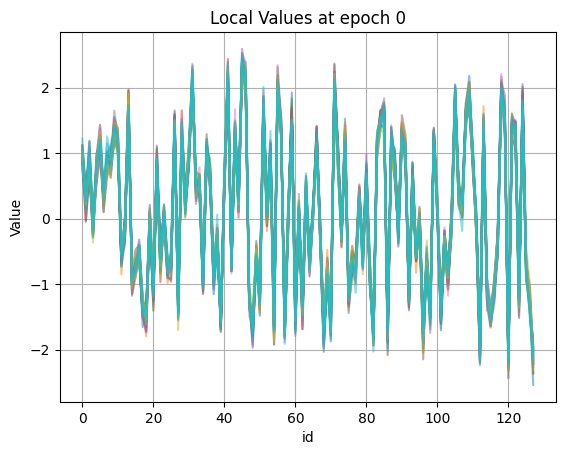

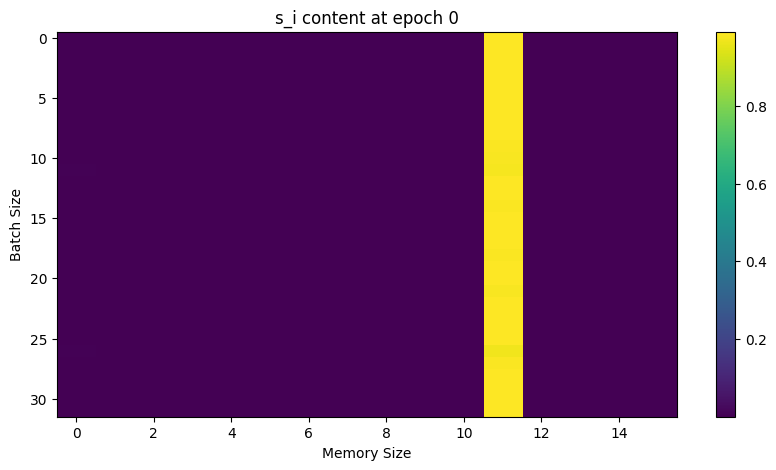

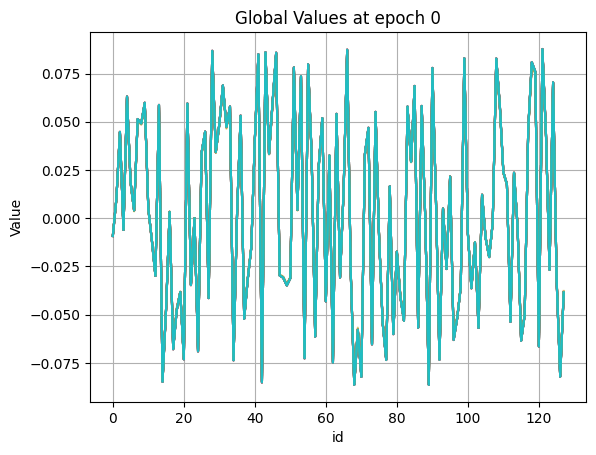

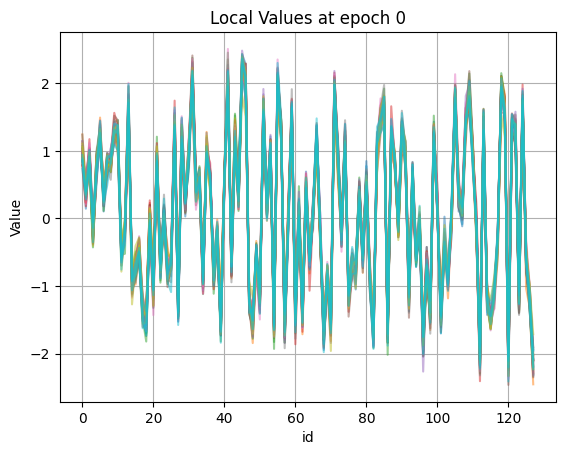

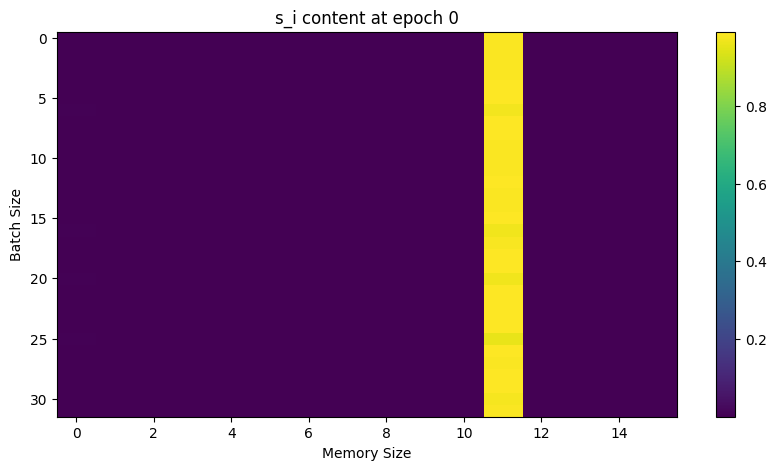

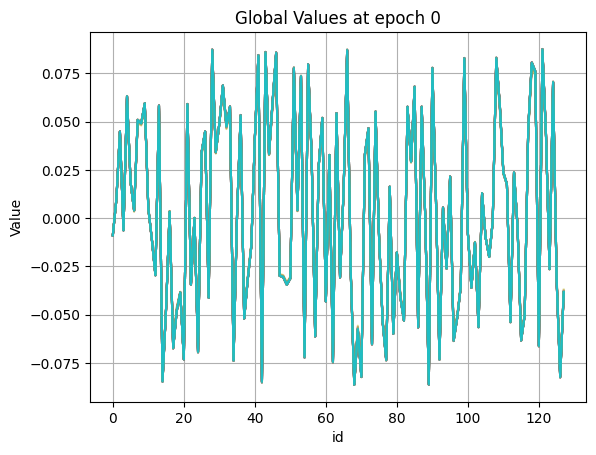

Epoch: 0, train_loss: 0.02523571, d_loss_real: 0.55756232, d_loss_fake: 0.48177147, valid_loss: 0.04182257, time: [26.2], best model: 1
Epoch 0: GPU memory allocated at end of epoch: 1204.53 MB


In [37]:
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as utils
from Discriminator import *
from LGnet_pre_bay import *


def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_pred * y_true)

def plot_heatmap(s_i, epoch):
    s_i_np = s_i.cpu().detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(s_i_np, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f's_i content at epoch {epoch}')
    plt.xlabel('Memory Size')
    plt.ylabel('Batch Size')
    plt.show()

def plot_memorymap(memory, epoch):
    memory_np = memory.cpu().detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(memory_np, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'memory content at epoch {epoch}')
    plt.xlabel('Memory Dim')
    plt.ylabel('Memoey Size')
    plt.show()

def plot_memory_mat_local(memory, epoch):
    memory_np = memory.cpu().detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(memory_np, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'matrix multiplication between memory and local_statistics.unsqueeze(-1) at epoch {epoch}')
    plt.xlabel('Memory Size')
    plt.ylabel('Batch Size')
    plt.show()

def plot_localglobal_graph(local_statistics, global_dynamics, batch_id, epoch):
    local_values = local_statistics[batch_id, :].cpu().detach().numpy()
    global_values = global_dynamics[batch_id, :].cpu().detach().numpy()
    num_dimensions = local_values.shape[0]

    indices = np.arange(num_dimensions)    
    plt.plot(indices, local_values, linestyle='-', label='local_statistics', color='r')
    plt.plot(indices, global_values, linestyle='-', label='global_dynamics', color='b')

    plt.xlabel('id')
    plt.ylabel('Value')
    plt.title(f'Local and Global Values at Batch ID {batch_id} and epoch {epoch}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_globals_graph(global_dynamics, epoch):
    global_values = global_dynamics[:, :].cpu().detach().numpy()
    num_dimensions = global_values.shape[1]
    num_batchs = global_values.shape[0]
    colors = plt.cm.get_cmap('tab10', num_batchs) 

    indices = np.arange(num_dimensions)
    for i, idx in enumerate(range(num_batchs)):
        if idx < num_batchs:
            values_index = global_values[idx, :]
            plt.plot(indices, values_index, linestyle='-', label=f'Values at Batch ID {i}', 
                        color=colors(i), alpha=0.5)

    plt.xlabel('id')
    plt.ylabel('Value')
    plt.title(f'Global Values at epoch {epoch}')
    #plt.legend()
    plt.grid(True)
    plt.show()

def plot_locals_graph(local_statistics, epoch):
    local_values = local_statistics[:, :].cpu().detach().numpy()
    num_dimensions = local_values.shape[1]
    num_batchs = local_values.shape[0]
    colors = plt.cm.get_cmap('tab10', num_batchs) 

    indices = np.arange(num_dimensions)
    for i, idx in enumerate(range(num_batchs)):
        if idx < num_batchs:
            values_index = local_values[idx, :]
            plt.plot(indices, values_index, linestyle='-', label=f'Values at Batch ID {i}', 
                        color=colors(i), alpha=0.5)

    plt.xlabel('id')
    plt.ylabel('Value')
    plt.title(f'Local Values at epoch {epoch}')
    #plt.legend()
    plt.grid(True)
    plt.show()

def plot_local_input_graph(z, z_prime, x_i, batch_id, epoch):
    z_values = z[batch_id, :].cpu().detach().numpy()
    z_prime_values = z_prime[batch_id, :].cpu().detach().numpy()
    x_i_values = x_i[batch_id, :].cpu().detach().numpy()
    num_dimensions = z_values.shape[0]

    indices = np.arange(num_dimensions)
      
    plt.plot(indices, z_values, linestyle='-', label='z', color='r', alpha=0.5)
    plt.plot(indices, z_prime_values, linestyle='-', label='z_prime', color='b', alpha=0.5)  
    plt.plot(indices, x_i_values, linestyle='-', label='x_i', color='g', alpha=0.5)

    plt.xlabel('id')
    plt.ylabel('Value')
    plt.title(f'Local input Values at Batch ID {batch_id} and epoch {epoch}')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()
    

def plot_losses_combined(losses_train, losses_valid, losses_d_real, losses_d_fake, filename):
    plt.figure(figsize=(10, 6))

    plt.plot(losses_train, label="Training Loss")
    plt.plot(losses_valid, label="Validation Loss")
    plt.plot(losses_d_real, label="Discriminator Real Loss")
    plt.plot(losses_d_fake, label="Discriminator Fake Loss")

    plt.title("Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.savefig(filename)
    plt.show()

def plot_sum_memory(memory, epoch):
    memory_np = memory.cpu().detach().numpy()
    # 各列の総和を計算
    column_sums = np.sum(memory_np, axis=1)

    # グラフを描画
    plt.figure(figsize=(10, 6))
    plt.plot(column_sums, marker='o', linestyle='-', color='b')
    plt.title('Sum of Each Row in Memory Tensor')
    plt.xlabel('Row Index')
    plt.ylabel('Sum')
    plt.grid(True)
    plt.show()


def PrepareDataset(
    speed_matrix,
    BATCH_SIZE=40,
    seq_len=10,
    pred_len=1,
    train_propotion=0.7,
    valid_propotion=0.2,
    masking=False,
    mask_ones_proportion=0.8,
    split_num=8,
):
    """Prepare training and testing datasets and dataloaders.

    Convert speed/volume/occupancy matrix to training and testing dataset.
    The vertical axis of speed_matrix is the time axis and the horizontal axis
    is the spatial axis.

    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """

    speed_matrix_s = np.array_split(speed_matrix, split_num)
    speed_matrix = speed_matrix_s[0]
    time_len = speed_matrix.shape[0]
    print("Time len: ", time_len)

    speed_matrix = speed_matrix.clip(0, 100)

    max_speed = speed_matrix.max().max()
    speed_matrix = speed_matrix / max_speed

    np.random.seed(1024)
    Mask = np.random.choice([0, 1], size=(speed_matrix.shape), p=[1 - mask_ones_proportion, mask_ones_proportion])
    speed_matrix_m = np.multiply(speed_matrix, Mask)

    speed_sequences, speed_labels, speed_labels_unmask = [], [], []
    for i in range(time_len - seq_len - pred_len):
        speed_sequences.append(speed_matrix_m.iloc[i : i + seq_len].values)
        speed_labels.append(speed_matrix_m.iloc[i + seq_len : i + seq_len + pred_len].values)
        speed_labels_unmask.append(speed_matrix.iloc[i + seq_len : i + seq_len + pred_len].values)
    speed_sequences, speed_labels, speed_labels_unmask = (
        np.asarray(speed_sequences),
        np.asarray(speed_labels),
        np.asarray(speed_labels_unmask),
    )

    # using zero-one mask to randomly set elements to zeros
    if masking:
        print("Split Speed finished. Start to generate Mask, Delta, Last_observed_X ...")
        Mask = np.where(speed_sequences == 0, 0, 1)
        Mask_l = np.where(speed_labels == 0, 0, 1)
        speed_sequences = np.multiply(speed_sequences, Mask)

        # temporal information
        interval = 5  # 5 minutes
        S = np.zeros_like(speed_sequences)  # time stamps
        for i in range(S.shape[1]):
            S[:, i, :] = interval * i

        Delta = np.zeros_like(speed_sequences)  # time intervals
        for i in range(1, S.shape[1]):
            Delta[:, i, :] = S[:, i, :] - S[:, i - 1, :]

        # Calculate Delta_b (backward direction)
        Delta_b = np.zeros_like(speed_sequences)
        for i in range(0, S.shape[1] - 1):
            Delta_b[:, i, :] = S[:, i + 1, :] - S[:, i, :]

        missing_index = np.where(Mask == 0)

        X_last_obsv = np.copy(speed_sequences)
        X_last_obsv_b = np.copy(speed_sequences)
        for idx in range(missing_index[0].shape[0]):
            i = missing_index[0][idx]
            j = missing_index[1][idx]
            k = missing_index[2][idx]
            if j != 0 and j != 9:
                Delta[i, j + 1, k] = Delta[i, j + 1, k] + Delta[i, j, k]
            if j != 0:
                X_last_obsv[i, j, k] = X_last_obsv[i, j - 1, k]  # last observation

        Delta = Delta / Delta.max()  # normalize

        for idx in range(missing_index[0].shape[0], -1):
            i = missing_index[0][idx]
            j = missing_index[1][idx]
            k = missing_index[2][idx]
            if j != 0 and j != 9:
                Delta_b[i, j - 1, k] += Delta_b[i, j, k] + Delta_b[i, j - 1, k]
            if j != 9:
                X_last_obsv_b[i, j, k] = X_last_obsv_b[i, j + 1, k]

        Delta_b = Delta_b / Delta_b.max()  # normalize

    # shuffle and split the dataset to training and testing datasets
    print("Generate Mask, Delta, Last_observed_X finished. Start to shuffle and split dataset ...")
    sample_size = speed_sequences.shape[0]
    index = np.arange(sample_size, dtype=int)
    # np.random.seed(1024)
    # np.random.shuffle(index)

    speed_sequences = speed_sequences[index]
    speed_labels = speed_labels[index]
    speed_labels_unmask = speed_labels_unmask[index]

    if masking:
        X_last_obsv = X_last_obsv[index]
        Mask = Mask[index]
        Delta = Delta[index]
        X_last_obsv_b = X_last_obsv_b[index]
        Delta_b = Delta_b[index]

        speed_sequences = np.expand_dims(speed_sequences, axis=1)
        X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
        Mask = np.expand_dims(Mask, axis=1)
        Delta = np.expand_dims(Delta, axis=1)
        X_last_obsv_b = np.expand_dims(X_last_obsv_b, axis=1)
        Delta_b = np.expand_dims(Delta_b, axis=1)

        dataset_agger = np.concatenate((speed_sequences, X_last_obsv, Mask, Delta, X_last_obsv_b, Delta_b), axis=1)

        speed_labels = np.expand_dims(speed_labels, axis=1)
        speed_labels_mask = np.expand_dims(Mask_l, axis=1)
        speed_labels_unmask = np.expand_dims(speed_labels_unmask, axis=1)

        speed_labels = np.concatenate((speed_labels, speed_labels_mask, speed_labels_unmask), axis=1)

    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * (train_propotion + valid_propotion)))

    if masking:
        train_data, train_label = dataset_agger[:train_index], speed_labels[:train_index]
        valid_data, valid_label = dataset_agger[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = dataset_agger[valid_index:], speed_labels[valid_index:]
    else:
        train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
        valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = speed_sequences[valid_index:], speed_labels[valid_index:]

    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)

    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    X_mean = np.mean(speed_sequences, axis=0)

    print("Finished")

    return train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean


def Train_Model(
    model,
    discriminator,
    train_dataloader,
    valid_dataloader,
    num_epochs=300,
    patience=10,
    min_delta=0.00001,
    lambda_dis=0.1,
):
    print("Model Structure: ", model)
    print("Start Training ... ")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    discriminator.to(device)

    if type(model) == nn.modules.container.Sequential:
        output_last = model[-1].output_last
        print("Output type dermined by the last layer")
    else:
        output_last = model.output_last
        print("Output type dermined by the model")

    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()

    learning_rate = 0.0001
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    optimizer_adv = torch.optim.RMSprop(discriminator.parameters(), lr=learning_rate)
    adversarial_loss = wasserstein_loss
    use_gpu = torch.cuda.is_available()

    interval = 100
    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    losses_epochs_d_loss_real = []
    losses_epochs_d_loss_fake = []

    cur_time = time.time()
    pre_time = time.time()

    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    for epoch in range(num_epochs):
        model.train()
        discriminator.train()
        # if use_gpu:
        #     mem_allocated = torch.cuda.memory_allocated() / (1024 * 1024)  # MB単位で取得
        #     print(f"Epoch {epoch}: GPU memory allocated at start of epoch: {mem_allocated:.2f} MB")

        trained_number = 0

        valid_dataloader_iter = iter(valid_dataloader)

        losses_epoch_train = []
        losses_epoch_valid = []

        losses_epoch_d_loss_real = []
        losses_epoch_d_loss_fake = []

        # if use_gpu:
        #     mem_allocated = torch.cuda.memory_allocated() / (1024 * 1024)  # MB単位で取得
        #     print(f"Epoch {epoch}: GPU memory allocated at before train: {mem_allocated:.2f} MB")

        i = 0 
        for data in train_dataloader:
            model.train()
            discriminator.train()
            inputs, labels = data

            if inputs.shape[0] != batch_size:
                continue

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels

            # print("inputs")
            # print(inputs.shape)

            optimizer_adv.zero_grad()

            forecasts, generation, forecast_by_memory = model(inputs)
            real_predictions = discriminator(torch.squeeze(labels[:, 0, :, :]))
            fake_predictions = discriminator(generation.detach())

            d_loss_real = adversarial_loss(real_predictions, torch.ones_like(real_predictions))
            d_loss_fake = adversarial_loss(fake_predictions, torch.ones_like(fake_predictions))

            d_loss = -d_loss_real + d_loss_fake
            # print(f"d_loss_real: {d_loss_real}")
            # print(f"d_loss_fake: {d_loss_fake}")

            losses_epoch_d_loss_real.append(d_loss_real.data)
            losses_epoch_d_loss_fake.append(d_loss_fake.data)

            d_loss.backward()

            optimizer_adv.step()

            # print("forecasts")
            # print(forecasts.shape)

            optimizer.zero_grad()

            # Forecasting
            outputs, generations, forecast_by_memory = model(inputs)

            forecasts_prediction = discriminator(generations.detach())
            g_loss_forecast = adversarial_loss(forecasts_prediction, torch.ones_like(forecasts_prediction))

            # print(f"generations: {generations.shape}")
            # print(f"forecasts_prediction: {forecasts_prediction.shape}")

            # print("outputs")
            # print(outputs.shape)
            # print("torch.squeeze(labels[:, 1, :, :])")
            # print(torch.squeeze(labels[:, 1, :, :]).shape)


            outputs = torch.mul(outputs[:, -1, :], torch.squeeze(labels[:, 1, :, :]))

            if output_last:
                loss_train = loss_MSE(torch.squeeze(outputs), torch.squeeze(labels[:, 0, :, :])) - lambda_dis * g_loss_forecast
            else:
                full_labels = torch.cat((inputs[:, 1:, :], labels), dim=1)
                loss_train = loss_MSE(outputs, full_labels) - lambda_dis * g_loss_forecast

            losses_train.append(loss_train.data)
            losses_epoch_train.append(loss_train.data)

            # print(f"loss_train: {loss_train}")

            loss_train.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # print(model.memory)

            # print(
            #     f"Epoch [{epoch}]  D Loss Real: {d_loss_real.item():.4f}  D Loss Fake: {d_loss_fake.item():.4f}  D Loss: {d_loss.item():.4f}"
            # )
            # print(
            #     f"Forecasting Loss: {loss.item():.4f}  G Loss Forecast: {g_loss_forecast.item():.4f}  G Loss: {g_loss.item():.4f}"
            # )

            if i < 10 and epoch % 50 ==0:
                plot_locals_graph(model.local_statistics, epoch)
                plot_heatmap(model.s_i, epoch)
                plot_globals_graph(model.global_dynamics, epoch)
                i += 1

            # validation
            model.eval()
            try:
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)

            if use_gpu:
                inputs_val, labels_val = inputs_val.cuda(), labels_val.cuda()
            else:
                inputs_val, labels_val = inputs_val, labels_val

            with torch.no_grad():
                outputs_val, generations, forecast_by_memory = model(inputs_val)

                outputs_val = torch.mul(outputs_val[:, -1, :], torch.squeeze(labels_val[:, 1, :, :]))

                if output_last:
                    loss_valid = loss_MSE(torch.squeeze(outputs_val), torch.squeeze(labels_val[:, 0, :, :]))
                else:
                    full_labels_val = torch.cat((inputs_val[:, 1:, :], labels_val), dim=1)
                    loss_valid = loss_MSE(outputs_val, full_labels_val)

            losses_valid.append(loss_valid.data)
            losses_epoch_valid.append(loss_valid.data)

            del inputs_val, labels_val, outputs_val, loss_valid, data
            torch.cuda.empty_cache()

            # if use_gpu:
            #     mem_allocated = torch.cuda.memory_allocated() / (1024 * 1024)  # MB単位で取得
            #     print(
            #         f"Epoch {epoch}, Step {trained_number}: GPU memory allocated after validation step: {mem_allocated:.2f} MB"
            #     )

            # output
            trained_number += 1

        # if epoch%25==0:
        #     plot_locals_graph(model.local_statistics, epoch)
        #     plot_heatmap(model.s_i, epoch)
        #     plot_globals_graph(model.global_dynamics, epoch)
        #     plot_memorymap(model.memory, epoch)
        #     plot_sum_memory(model.memory, epoch)
        #     plot_local_input_graph(model.z, model.z_prime, model.x_i, 0, epoch)
        #     plot_localglobal_graph(model.local_statistics, model.global_dynamics, 0, epoch)
        #     plot_memory_mat_local(torch.matmul(model.memory, model.local_statistics.unsqueeze(-1)).squeeze(-1),epoch)
            
        avg_losses_epoch_train = sum(losses_epoch_train).cpu().numpy() / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid).cpu().numpy() / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)

        avg_losses_epoch_d_loss_real = sum(losses_epoch_d_loss_real).cpu().numpy() / float(
            len(losses_epoch_d_loss_real)
        )
        avg_losses_epoch_d_loss_fake = sum(losses_epoch_d_loss_fake).cpu().numpy() / float(
            len(losses_epoch_d_loss_fake)
        )
        losses_epochs_d_loss_real.append(avg_losses_epoch_d_loss_real)
        losses_epochs_d_loss_fake.append(avg_losses_epoch_d_loss_fake)

        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print("Early Stopped at Epoch:", epoch)
                    plot_locals_graph(model.local_statistics, epoch)
                    plot_heatmap(model.s_i, epoch)
                    plot_globals_graph(model.global_dynamics, epoch)
                    plot_memorymap(model.memory, epoch)
                    plot_sum_memory(model.memory, epoch)
                    plot_local_input_graph(model.z, model.z_prime, model.x_i, 0, epoch)
                    plot_localglobal_graph(model.local_statistics, model.global_dynamics, 0, epoch)
                    plot_memory_mat_local(torch.matmul(model.memory, model.local_statistics.unsqueeze(-1)).squeeze(-1),epoch)
                    break

        # Print training parameters
        cur_time = time.time()
        print(
            "Epoch: {}, train_loss: {}, d_loss_real: {}, d_loss_fake: {}, valid_loss: {}, time: {}, best model: {}".format(
                epoch,
                np.around(avg_losses_epoch_train, decimals=8),
                np.around(avg_losses_epoch_d_loss_real, decimals=8),
                np.around(avg_losses_epoch_d_loss_fake, decimals=8),
                np.around(avg_losses_epoch_valid, decimals=8),
                np.around([cur_time - pre_time], decimals=2),
                is_best_model,
            )
        )
        pre_time = cur_time

        if use_gpu:
            mem_allocated = torch.cuda.memory_allocated() / (1024 * 1024)  # MB単位で取得
            print(f"Epoch {epoch}: GPU memory allocated at end of epoch: {mem_allocated:.2f} MB")

    plot_losses_combined(
        losses_epochs_train,
        losses_epochs_valid,
        losses_epochs_d_loss_real,
        losses_epochs_d_loss_fake,
        "combined_losses.png",
    )

    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]


def Test_Model(model, test_dataloader, max_speed):
    if type(model) == nn.modules.container.Sequential:
        output_last = model[-1].output_last
    else:
        output_last = model.output_last

    inputs, labels = next(iter(test_dataloader))
    [batch_size, type_size, step_size, fea_size] = inputs.size()

    cur_time = time.time()
    pre_time = time.time()

    use_gpu = torch.cuda.is_available()

    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.MSELoss()

    tested_batch = 0

    losses_mse = []
    losses_l1 = []
    MAEs = []
    MAPEs = []

    for data in test_dataloader:
        inputs, labels = data

        if inputs.shape[0] != batch_size:
            continue

        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        outputs, generation, forecast_by_memory = model(inputs)

        loss_MSE = torch.nn.MSELoss()
        loss_L1 = torch.nn.L1Loss()

        if output_last:
            loss_mse = loss_MSE(torch.squeeze(outputs[:, -1, :]), torch.squeeze(labels[:, 2, :, :]))
            loss_l1 = loss_L1(torch.squeeze(outputs[:, -1, :]), torch.squeeze(labels[:, 2, :, :]))
            MAE = torch.mean(torch.abs(torch.squeeze(outputs[:, -1, :]) - torch.squeeze(labels[:, 2, :, :])))
            MAPE = torch.mean(
                torch.abs(torch.squeeze(outputs[:, -1, :]) - torch.squeeze(labels[:, 2, :, :]))
                / torch.squeeze(labels[:, 2, :, :])
            )
        else:
            loss_mse = loss_MSE(outputs[:, -1, :], labels)
            loss_l1 = loss_L1(outputs[:, -1, :], labels)
            MAE = torch.mean(torch.abs(outputs[:, -1, :] - torch.squeeze(labels)))
            MAPE = torch.mean(torch.abs(outputs[:, -1, :] - torch.squeeze(labels)) / torch.squeeze(labels))

        losses_mse.append(loss_mse.data.cpu().numpy())  # Move to CPU and convert to NumPy array
        losses_l1.append(loss_l1.data.cpu().numpy())  # Move to CPU and convert to NumPy array
        MAEs.append(MAE.data.cpu().numpy())  # Move to CPU and convert to NumPy array
        MAPEs.append(MAPE.data.cpu().numpy())  # Move to CPU and convert to NumPy array

        tested_batch += 1

        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print(
                "Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}".format(
                    tested_batch * batch_size,
                    np.around([loss_l1.data[0]], decimals=8),
                    np.around([loss_mse.data[0]], decimals=8),
                    np.around([cur_time - pre_time], decimals=8),
                )
            )
            pre_time = cur_time
    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    MAEs = np.array(MAEs)
    MAPEs = np.array(MAPEs)

    mean_l1 = np.mean(losses_l1) * max_speed
    std_l1 = np.std(losses_l1) * max_speed
    MAE_ = np.mean(MAEs) * max_speed
    MAPE_ = np.mean(MAPEs) * 100

    print("Tested: L1_mean: {}, L1_std: {}, MAE: {} MAPE: {}".format(mean_l1, std_l1, MAE_, MAPE_))
    return [losses_l1, losses_mse, mean_l1, std_l1]


if __name__ == "__main__":
    data = "BAY"
    if data == "inrix":
        speed_matrix = pd.read_pickle("../Data_Warehouse/Data_network_traffic/inrix_seattle_speed_matrix_2012")
    elif data == "loop":
        speed_matrix = pd.read_pickle("/workspaces/STdata_prediction/src/GRU-D-zhiyongc/input/speed_matrix_2015")
        np.random.seed(1024)
        mask_ones_proportion=0.8
        Mask = np.random.choice(
            [0, 1], size=(speed_matrix.shape), p=[1 - mask_ones_proportion, mask_ones_proportion]
        )
        speed_matrix = np.multiply(speed_matrix, Mask)
    elif data == "LA":
        with h5py.File("/workspaces/STdata_prediction/src/LGnet/input/metr-la.h5", "r") as f:
            # dfグループ内のデータセットを取得
            df_group = f["df"]

            # 各データセットを取得
            axis0 = df_group["axis0"][:]
            axis1 = df_group["axis1"][:]
            block0_items = df_group["block0_items"][:]
            block0_values = df_group["block0_values"][:]

            # DataFrameの作成
            speed_matrix = pd.DataFrame(block0_values, index=axis1, columns=block0_items)
    elif data == "BAY":
        with h5py.File("/workspaces/STdata_prediction/src/LGnet/input/pems-bay.h5", "r") as f:
            # dfグループ内のデータセットを取得
            df_group = f["speed"]

            # 各データセットを取得
            axis0 = df_group["axis0"][:]
            axis1 = df_group["axis1"][:]
            block0_items = df_group["block0_items"][:]
            block0_values = df_group["block0_values"][:]

            # DataFrameの作成
            speed_matrix = pd.DataFrame(block0_values, index=axis1, columns=block0_items)

    train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean = PrepareDataset(
        speed_matrix, BATCH_SIZE=32, masking=True, mask_ones_proportion=0.8, split_num=64
    )

    inputs, labels = next(iter(train_dataloader))
    [batch_size, type_size, step_size, fea_size] = inputs.size()
    input_dim = fea_size
    hidden_dim = fea_size
    output_dim = fea_size

    lgnet = LGnet(
        input_dim, hidden_dim, output_dim, X_mean, memory_size=16, memory_dim=128, num_layers=1, output_last=True
    )
    adv = Discriminator(input_dim)
    best_lgnet, losses_lgnet = Train_Model(lgnet, adv, train_dataloader, valid_dataloader, lambda_dis=0.1)
    [losses_l1, losses_mse, mean_l1, std_l1] = Test_Model(best_lgnet, test_dataloader, max_speed)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

def Test_Model(model, test_dataloader, max_speed):
    if type(model) == nn.modules.container.Sequential:
        output_last = model[-1].output_last
    else:
        output_last = model.output_last

    inputs, labels = next(iter(test_dataloader))
    [batch_size, type_size, step_size, fea_size] = inputs.size()

    cur_time = time.time()
    pre_time = time.time()

    use_gpu = torch.cuda.is_available()

    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.MSELoss()

    tested_batch = 0

    losses_mse = []
    losses_l1 = []
    MAEs = []
    MAPEs = []

    all_labels = []
    all_outputs = []
    all_inputs = []

    for data in test_dataloader:
        inputs, labels = data

        if inputs.shape[0] != batch_size:
            continue

        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        outputs, generation = model(inputs)

        loss_MSE = torch.nn.MSELoss()
        loss_L1 = torch.nn.L1Loss()

        if output_last:
            loss_mse = loss_MSE(torch.squeeze(outputs[:, -1, :]), torch.squeeze(labels[:, 2, :, :]))
            loss_l1 = loss_L1(torch.squeeze(outputs[:, -1, :]), torch.squeeze(labels[:, 2, :, :]))
            MAE = torch.mean(torch.abs(torch.squeeze(outputs[:, -1, :]) - torch.squeeze(labels[:, 2, :, :])))
            MAPE = torch.mean(
                torch.abs(torch.squeeze(outputs[:, -1, :]) - torch.squeeze(labels[:, 2, :, :]))
                / torch.squeeze(labels[:, 2, :, :])
            )
            all_labels.append(labels.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            all_inputs.append(inputs.cpu().detach().numpy())

        else:
            loss_mse = loss_MSE(outputs[:, -1, :], labels)
            loss_l1 = loss_L1(outputs[:, -1, :], labels)
            MAE = torch.mean(torch.abs(outputs[:, -1, :] - torch.squeeze(labels)))
            MAPE = torch.mean(torch.abs(outputs[:, -1, :] - torch.squeeze(labels)) / torch.squeeze(labels))

            all_labels.append(labels.cpu().detach().numpy())
            all_outputs.append(outputs[:, -1, :].cpu().detach().numpy())
            all_inputs.append(inputs.cpu().detach().numpy())

        losses_mse.append(loss_mse.data.cpu().numpy())
        losses_l1.append(loss_l1.data.cpu().numpy())
        MAEs.append(MAE.data.cpu().numpy())
        MAPEs.append(MAPE.data.cpu().numpy())

        tested_batch += 1

        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print(
                "Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}".format(
                    tested_batch * batch_size,
                    np.around([loss_l1.data[0]], decimals=8),
                    np.around([loss_mse.data[0]], decimals=8),
                    np.around([cur_time - pre_time], decimals=8),
                )
            )
            pre_time = cur_time

    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    MAEs = np.array(MAEs)
    MAPEs = np.array(MAPEs)

    mean_l1 = np.mean(losses_l1) * max_speed
    std_l1 = np.std(losses_l1) * max_speed
    MAE_ = np.mean(MAEs) * max_speed
    MAPE_ = np.mean(MAPEs) * 100

    print("Tested: L1_mean: {}, L1_std: {}, MAE: {} MAPE: {}".format(mean_l1, std_l1, MAE_, MAPE_))

    all_labels = np.concatenate(all_labels, axis=0)
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_inputs = np.concatenate(all_inputs,axis=0)

    return [losses_l1, losses_mse, mean_l1, std_l1, all_labels, all_outputs, all_inputs]

def plot_histograms(true_values, predicted_values, bins=50):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    true_hist = plt.hist(true_values, bins=bins, alpha=0.7, label='True Values')
    plt.title('Histogram of True Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    predicted_hist = plt.hist(predicted_values, bins=bins, alpha=0.7, label='Predicted Values')
    plt.title('Histogram of Predicted Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    # Align y-axis limits
    max_y = max(true_hist[0].max(), predicted_hist[0].max())
    plt.subplot(1, 2, 1)
    plt.ylim(0, max_y)
    plt.subplot(1, 2, 2)
    plt.ylim(0, max_y)

    plt.show()

# Example usage
# Assuming `test_dataloader` and `model` are already defined and loaded
max_speed = 100  # Example value, replace with actual max_speed
results = Test_Model(lgnet, test_dataloader, max_speed)
losses_l1, losses_mse, mean_l1, std_l1, all_labels, all_outputs, all_inputs = results

plot_histograms(all_labels[:, 2, :, :].flatten(), all_outputs[:, -1, :].flatten(), bins=50)


In [ ]:
def plot_step_graph(true_values, predicted_values, input_values, time_index, id):
    true_values_time = np.append(input_values[time_index,0,:,id] ,true_values[time_index, id])
    predicted_values_time = predicted_values[time_index, :, id]
    num_dimensions = true_values_time.shape[0]

    indices = np.arange(num_dimensions)
    predicted_indices = np.arange(1, predicted_values_time.shape[0] + 1)
    plt.plot(predicted_indices, predicted_values_time, linestyle='-', label='Predicted Values', color='r')
    plt.plot(indices, true_values_time, linestyle='-', label='input Values', color='b')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Input, True and Predicted Values at Time Index {time_index} and ID {id}')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

plot_step_graph(all_labels[:, 2, :, :].squeeze(), all_outputs, all_inputs, 0, 0)

In [ ]:
def plot_bar_graph(true_values, predicted_values, time_index):
    true_values_time = true_values[time_index, :]
    predicted_values_time = predicted_values[time_index, :]
    num_dimensions = true_values_time.shape[0]

    plt.figure(figsize=(12, 8))
    indices = np.arange(num_dimensions)

    plt.plot(indices, true_values_time, linestyle='-', label='True Values', color='b')
    plt.plot(indices, predicted_values_time, linestyle='-', label='Predicted Values', color='r')

    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.title(f'True and Predicted Values at Time Index {time_index}')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

time_index_to_visualize = 0
plot_bar_graph(all_labels[:, 2, :, :].squeeze(), all_outputs[:, -1, :].squeeze(), time_index_to_visualize)

In [ ]:
def calculate_mae_mape(true_values, predicted_values):
    mae_per_timestep = np.mean(np.abs(true_values - predicted_values), axis=1)
    mape_per_timestep = np.mean(np.abs((true_values - predicted_values) / true_values), axis=1) * 100

    return mae_per_timestep, mape_per_timestep

def find_extreme_indices(mae_per_timestep, mape_per_timestep):
    mae_min_index = np.argmin(mae_per_timestep)
    mae_max_index = np.argmax(mae_per_timestep)
    mape_min_index = np.argmin(mape_per_timestep)
    mape_max_index = np.argmax(mape_per_timestep)

    return mae_min_index, mae_max_index, mape_min_index, mape_max_index

# Example usage
# Assuming `all_labels` and `all_outputs` are obtained from the Test_Model function

mae_per_timestep, mape_per_timestep = calculate_mae_mape(all_labels[:, 2, :, :].squeeze(), all_outputs[:, -1, :].squeeze())
mae_min_index, mae_max_index, mape_min_index, mape_max_index = find_extreme_indices(mae_per_timestep, mape_per_timestep)

In [ ]:
def plot_min_graph(true_values, predicted_values, time_index):
    true_values_time = true_values[time_index, :]
    predicted_values_time = predicted_values[time_index, :]
    num_dimensions = true_values_time.shape[0]

    plt.figure(figsize=(12, 8))
    indices = np.arange(num_dimensions)

    plt.plot(indices, true_values_time, linestyle='-', label='True Values', color='b')
    plt.plot(indices, predicted_values_time, linestyle='-', label='Predicted Values', color='r')

    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.title(f'True and Predicted Values at MAE MIN Index {time_index}: {mae_per_timestep[time_index]* max_speed}')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

def plot_max_graph(true_values, predicted_values, time_index):
    true_values_time = true_values[time_index, :]
    predicted_values_time = predicted_values[time_index, :]
    num_dimensions = true_values_time.shape[0]

    plt.figure(figsize=(12, 8))
    indices = np.arange(num_dimensions)

    plt.plot(indices, true_values_time, linestyle='-', label='True Values', color='b')
    plt.plot(indices, predicted_values_time, linestyle='-', label='Predicted Values', color='r')

    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.title(f'True and Predicted Values at MAE MAX Index {time_index}: {mae_per_timestep[time_index]* max_speed}')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

In [ ]:
plot_min_graph(all_labels[:, 2, :, :].squeeze(), all_outputs[:, -1, :].squeeze(), mae_min_index)
plot_max_graph(all_labels[:, 2, :, :].squeeze(), all_outputs[:, -1, :].squeeze(), mae_max_index)

In [ ]:
print(all_labels.shape)
print(all_outputs.shape)
print(all_inputs.shape)